#  AI 发现物理规律：PhyE2E 完整教学实验

**基于 Nature Machine Intelligence 论文：A Neural Symbolic Model for Space Physics**

---

##  课程简介

本实验将带你体验如何使用 AI（PhyE2E 模型）从观测数据中自动发现物理规律。你将学习：

1. **传统拟合方法**的原理与局限性
2. **符号回归**的核心思想
3. **PhyE2E** 模型的使用方法
4. 在**真实物理数据**上发现公式
5. **对比分析**不同方法的优劣

---

---
<a id='第零部分'></a>
# 第零部分: 环境准备

本部分将完成所有必要的环境配置，包括：
- GPU 检测
- 代码仓库克隆
- 依赖安装
- 模型和数据下载

In [3]:
#@title ##0.1 检查运行环境
#markdown **重要**：请确保已切换到 GPU 运行时！
#@markdown 检测 Python、PyTorch 版本及 GPU 可用性。

# 检测运行环境
import torch
import sys
import os

print("="*60)
print(" 环境检测")
print("="*60)

# Python 版本
print(f"\n Python 版本: {sys.version}")

# PyTorch 版本
print(f" PyTorch 版本: {torch.__version__}")

# GPU 检测
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"\n GPU 可用: {gpu_name}")
    print(f" GPU 显存: {gpu_memory:.1f} GB")
else:
    print("\n 未检测到 GPU！")
    print(" 请切换到 GPU 运行时")

# 检测是否在 Colab 环境
IN_COLAB = 'google.colab' in sys.modules
print(f"\n 运行环境: {'Google Colab' if IN_COLAB else '本地环境'}")

print("\n" + "="*60)

 环境检测

 Python 版本: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
 PyTorch 版本: 2.9.0+cu126

 GPU 可用: NVIDIA A100-SXM4-40GB
 GPU 显存: 42.5 GB

 运行环境: Google Colab



In [4]:
#@title ##0.2 配置绘图环境
#@markdown 配置 matplotlib

import matplotlib.pyplot as plt
import warnings

# 使用默认字体（避免中文显示问题）
plt.rcParams['font.family'] = ['DejaVu Sans', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 11
plt.rcParams['figure.figsize'] = (10, 6)

# 忽略字体警告
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')

print('绑图环境配置完成')

绑图环境配置完成


In [5]:
#@title ## 0.3 克隆仓库
#@markdown 从 GitHub 克隆 PhyE2E 项目代码

# 克隆 PhysicsRegression 仓库
import os

REPO_DIR = "PhysicsRegression"

if os.path.exists(REPO_DIR):
    print(f"仓库已存在: {REPO_DIR}")
else:
    print("正在克隆仓库...")
    !git clone https://github.com/Jie0618/PhysicsRegression.git
    print("克隆完成！")

# 验证
!ls {REPO_DIR}/*.py | head -5

正在克隆仓库...
Cloning into 'PhysicsRegression'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (254/254), done.
remote: Compressing objects: 100% (172/172), done.
remote: Total 254 (delta 119), reused 151 (delta 70), pack-reused 0 (from 0)
Receiving objects: 100% (254/254), 2.76 MiB | 10.62 MiB/s, done.
Resolving deltas: 100% (119/119), done.
克隆完成！
PhysicsRegression/evaluate.py
PhysicsRegression/parsers.py
PhysicsRegression/PhysicsRegression.py
PhysicsRegression/train.py


In [6]:
#@title ##0.4 安装依赖
#@markdown 安装 PhyE2E 所需的 Python 包

# 安装必要的依赖
print(" 正在安装依赖...")

# 基础科学计算库（通常已预装）
!pip install -q numpy pandas matplotlib scipy sympy tqdm

# 用于下载 Google Drive 文件
!pip install -q gdown

# 用于交互式控件
!pip install -q ipywidgets

# 检查 environment.yml 中的其他依赖
!pip install -q scikit-learn

print("\n 依赖安装完成！")

 正在安装依赖...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 80.2 MB/s eta 0:00:00

 依赖安装完成！


In [7]:
#@title ## 0.5 下载预训练模型
#@markdown 从 Google Drive 下载训练好的 PhyE2E 模型

import os
import gdown
import shutil

MODEL_PATH = f"{REPO_DIR}/model.pt"
MODEL_FOLDER_ID = "14M0Ed0gvSKmtuTOornfEoup8l48IfEUW"

# 删除损坏的文件
if os.path.exists(MODEL_PATH) and os.path.getsize(MODEL_PATH) < 1024*1024:
    os.remove(MODEL_PATH)
    print("已删除损坏文件")

# 下载模型
if not os.path.exists(MODEL_PATH):
    print("正在下载模型，请稍候...")
    gdown.download_folder(
        f"https://drive.google.com/drive/folders/{MODEL_FOLDER_ID}",
        output=f"{REPO_DIR}/",
        quiet=False
    )

    # 修复路径问题（gdown可能会创建嵌套目录）
    nested_path = f"{REPO_DIR}/PhysicsRegression/model/model.pt"
    nested_path2 = f"{REPO_DIR}/model/model.pt"

    if os.path.exists(nested_path):
        shutil.move(nested_path, MODEL_PATH)
        shutil.rmtree(f"{REPO_DIR}/PhysicsRegression", ignore_errors=True)
        print("已修复文件路径")
    elif os.path.exists(nested_path2):
        shutil.move(nested_path2, MODEL_PATH)
        shutil.rmtree(f"{REPO_DIR}/model", ignore_errors=True)
        print("已修复文件路径")

# 验证
if os.path.exists(MODEL_PATH):
    size_mb = os.path.getsize(MODEL_PATH) / (1024*1024)
    if size_mb > 1:
        print(f"\n✓ 下载成功！model.pt: {size_mb:.1f} MB")
    else:
        print(f"\n✗ 文件太小 ({size_mb:.2f} MB)")
else:
    print("\n✗ 下载失败，请手动下载")
    print("链接: https://drive.google.com/drive/folders/14M0Ed0gvSKmtuTOornfEoup8l48IfEUW")

已删除损坏文件
正在下载模型，请稍候...


Retrieving folder contents


Processing file 1szeTQmqSkl8DPBq2aXoHzEOusg-R1sx0 model.pt


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1szeTQmqSkl8DPBq2aXoHzEOusg-R1sx0
From (redirected): https://drive.google.com/uc?id=1szeTQmqSkl8DPBq2aXoHzEOusg-R1sx0&confirm=t&uuid=4a90a37c-7d2c-4ed8-b074-c86d3978e36d
To: /content/PhysicsRegression/model/model.pt
100%|██████████| 374M/374M [00:07<00:00, 47.8MB/s]

已修复文件路径

✓ 下载成功！model.pt: 356.2 MB



Download completed


In [8]:
#@title ## 0.6 下载数据集和 Oracle 模型
#@markdown 从 Google Drive 下载模型或数据

# 数据文件夹链接
# https://drive.google.com/drive/folders/17rbDLb2ZBgK9DidJtb1nyBFmGtOokhYs
DATA_FOLDER_ID = "17rbDLb2ZBgK9DidJtb1nyBFmGtOokhYs"

# Oracle 模型文件夹链接
# https://drive.google.com/drive/folders/1VfH7Rp25U_pE504uhEd7dhSyvsBSXHdo
ORACLE_FOLDER_ID = "1VfH7Rp25U_pE504uhEd7dhSyvsBSXHdo"

print("正在下载数据集...")
print("文件较大，请耐心等待...\n")

# 创建 data 目录
os.makedirs(f"{REPO_DIR}/data", exist_ok=True)

try:
    # 下载数据
    gdown.download_folder(
        f"https://drive.google.com/drive/folders/{DATA_FOLDER_ID}",
        output=f"{REPO_DIR}/data/",
        quiet=False
    )
    print("\n 数据集下载完成！")
except Exception as e:
    print(f"\n数据下载遇到问题: {e}")
    print("部分功能可能受限，但基础演示仍可进行")

print("\n" + "-"*40)
print("正在下载 Oracle 模型...\n")

# 创建 Oracle_model 目录
os.makedirs(f"{REPO_DIR}/Oracle_model", exist_ok=True)

try:
    gdown.download_folder(
        f"https://drive.google.com/drive/folders/{ORACLE_FOLDER_ID}",
        output=f"{REPO_DIR}/Oracle_model/",
        quiet=False
    )
    print("\n Oracle 模型下载完成！")
except Exception as e:
    print(f"\n Oracle 模型下载遇到问题: {e}")
    print("D&C 功能可能受限，但不影响本次实验使用。")

正在下载数据集...
文件较大，请耐心等待...



Retrieving folder contents


Retrieving folder 1IagXIUZT0yZu3QM9ipJrbWriAwbo0Tqr data
Retrieving folder 1mS_BA-T7xupP3KgiMQ_I6mVfheXf7H2X physics_data
Processing file 1Ab5k9R7cV498a1onWtTnRVqhiJJ74x3v Fe X     174.531    1 -   30 3s2 3p5 2P1.5 - 3s2 3p4 3d 2D2.5.csv
Processing file 1XUzlidVuWpxnDyO6N22GpXfNO5K8M8oH Fe X     175.263    2 -   31 3s2 3p5 2P0.5 - 3s2 3p4 3d 2D1.5.csv
Processing file 1ZhNAyWPW0AYHLNgc0eyc9pqjGTf0vhKb SN_m_tot_V2.0.txt
Processing file 1QpSbtxXCnhpyLPHFZEyH8c9wDQUQYuYO solarDifferentialRotation.csv
Processing file 13W3AUgIicYzWD_jutrPIklZNozwjbPh7 TH-Gt_beta-ge-0.1_Kp=0_Pd=1.5_50-quartile.txt
Processing file 1rxAaFkNdoMjBNiskJZzxCUSfOOkVVLmk TH-Gt_beta-ge-0.1_Kp=0_Pd=3.0_50-quartile.txt
Processing file 167-l4U4hCAx1pyiGGVSmwg_hPAukQ_tM TH-Gt_beta-ge-0.1_Kp=1_Pd=1.5_50-quartile.txt
Processing file 1O_j56_qj-hBmtteDGgZmx3fyr-FAC8H1 TH-Gt_beta-ge-0.1_Kp=1_Pd=3.0_50-quartile.txt
Processing file 1I9BpqBaXnlBmxGuD2Wbw6lwZThHCn6xa TH-Gt_beta-ge-0.1_Kp=2_Pd=1.5_50-quartile.txt
Processing file 1F

Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1Ab5k9R7cV498a1onWtTnRVqhiJJ74x3v
To: /content/PhysicsRegression/data/data/data/physics_data/Fe X     174.531    1 -   30 3s2 3p5 2P1.5 - 3s2 3p4 3d 2D2.5.csv
100%|██████████| 147k/147k [00:00<00:00, 113MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XUzlidVuWpxnDyO6N22GpXfNO5K8M8oH
To: /content/PhysicsRegression/data/data/data/physics_data/Fe X     175.263    2 -   31 3s2 3p5 2P0.5 - 3s2 3p4 3d 2D1.5.csv
100%|██████████| 147k/147k [00:00<00:00, 76.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZhNAyWPW0AYHLNgc0eyc9pqjGTf0vhKb
To: /content/PhysicsRegression/data/data/data/physics_data/SN_m_tot_V2.0.txt
100%|██████████| 125k/125k [00:00<00:00, 107MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QpSbtxXCnhpyLPHFZEyH8c9wDQUQYuYO
To: /content/PhysicsRegression/data/data/data/physics_data/solarDifferent


 数据集下载完成！

----------------------------------------
正在下载 Oracle 模型...

Retrieving folder 1RwoiqK_E-ay-u5czBj9UjlcqfzxhN5yU Oracle_model
Retrieving folder 1L0onlFje76Qr1HUp2SGqK9LjTKD_0jJY feynman
Processing file 18u43G4kR4sWCYbeJi_Lg1Ud6B4x2s_pI feynman_0.pth
Processing file 1r1J0GsV0gGsSXb_B2inNDQe2KXDTbeoE feynman_1.pth
Processing file 1AiT_6dEd8gDYHqnVXPPFpGz06B8JX3kC feynman_2.pth
Processing file 1yjmcPpyr1NusWl6Y8Hh9qjunuvSrFbnN feynman_3.pth
Processing file 1HlwZaEkUFXz32JEXJ92q6lqUX45-nAaJ feynman_4.pth
Processing file 1kzK_cg1gqGOP4vPTdWV8nkzoKETi8zuJ feynman_5.pth
Processing file 1aLqRIBkadubLsIDEdYyhMZ_AbET-uxXe feynman_6.pth
Processing file 1IlqKPvJPAA2bkjQ6yU3e5PLCtbIoemq_ feynman_7.pth
Processing file 16q75eYYyODmM7Ifx2VtWn89lY-10BCnn feynman_8.pth
Processing file 1mRUiXH6JrYwNtu4zW7xEKQB7jZq1z6kr feynman_9.pth
Processing file 1Z4-FVQb4UnUkmA4Zr9opmCjgGGdIGy6R feynman_10.pth
Processing file 1fZsx98BZp-Z0STvQtlcgLluGsxJ849TT feynman_11.pth
Processing file 13vkw1voIZmKqoX0n

In [9]:
#@title ## 0.7 环境验证
#@markdown 验证所有组件是否正确安装和配置

import os
import sys

# 添加仓库到 Python 路径
sys.path.insert(0, REPO_DIR)
os.chdir(REPO_DIR)

print("="*60)
print(" 环境验证")
print("="*60)

# 检查关键文件
critical_files = [
    "model.pt",
    "PhysicsRegression.py",
    "evaluate.py",
    "parsers.py"
]

print("\n 检查关键文件:")
all_files_exist = True
for f in critical_files:
    exists = os.path.exists(f)
    status = "" if exists else ""
    print(f"  {status} {f}")
    if not exists:
        all_files_exist = False

# 检查目录
critical_dirs = ["data", "Oracle_model", "physical", "symbolicregression"]
print("\n 检查关键目录:")
for d in critical_dirs:
    exists = os.path.isdir(d)
    status = "" if exists else ""
    print(f"  {status} {d}/")

# 尝试导入核心模块
print("\n 检查模块导入:")
modules_to_check = ['numpy', 'pandas', 'sympy', 'torch', 'matplotlib']
for mod in modules_to_check:
    try:
        __import__(mod)
        print(f"   {mod}")
    except ImportError:
        print(f"   {mod}")

print("\n" + "="*60)
if all_files_exist:
    print(" 环境配置完成！可以开始实验了！")
else:
    print(" 部分文件缺失，请检查上述步骤")
print("="*60)

 环境验证

 检查关键文件:
   model.pt
   PhysicsRegression.py
   evaluate.py
   parsers.py

 检查关键目录:
   data/
   Oracle_model/
   physical/
   symbolicregression/

 检查模块导入:
   numpy
   pandas
   sympy
   torch
   matplotlib

 环境配置完成！可以开始实验了！


---
<a id='第一部分'></a>
# 第一部分: 传统拟合方法（基准线）

在学习 AI 符号回归之前，我们先回顾传统的曲线拟合方法，理解它们的能力和局限性。

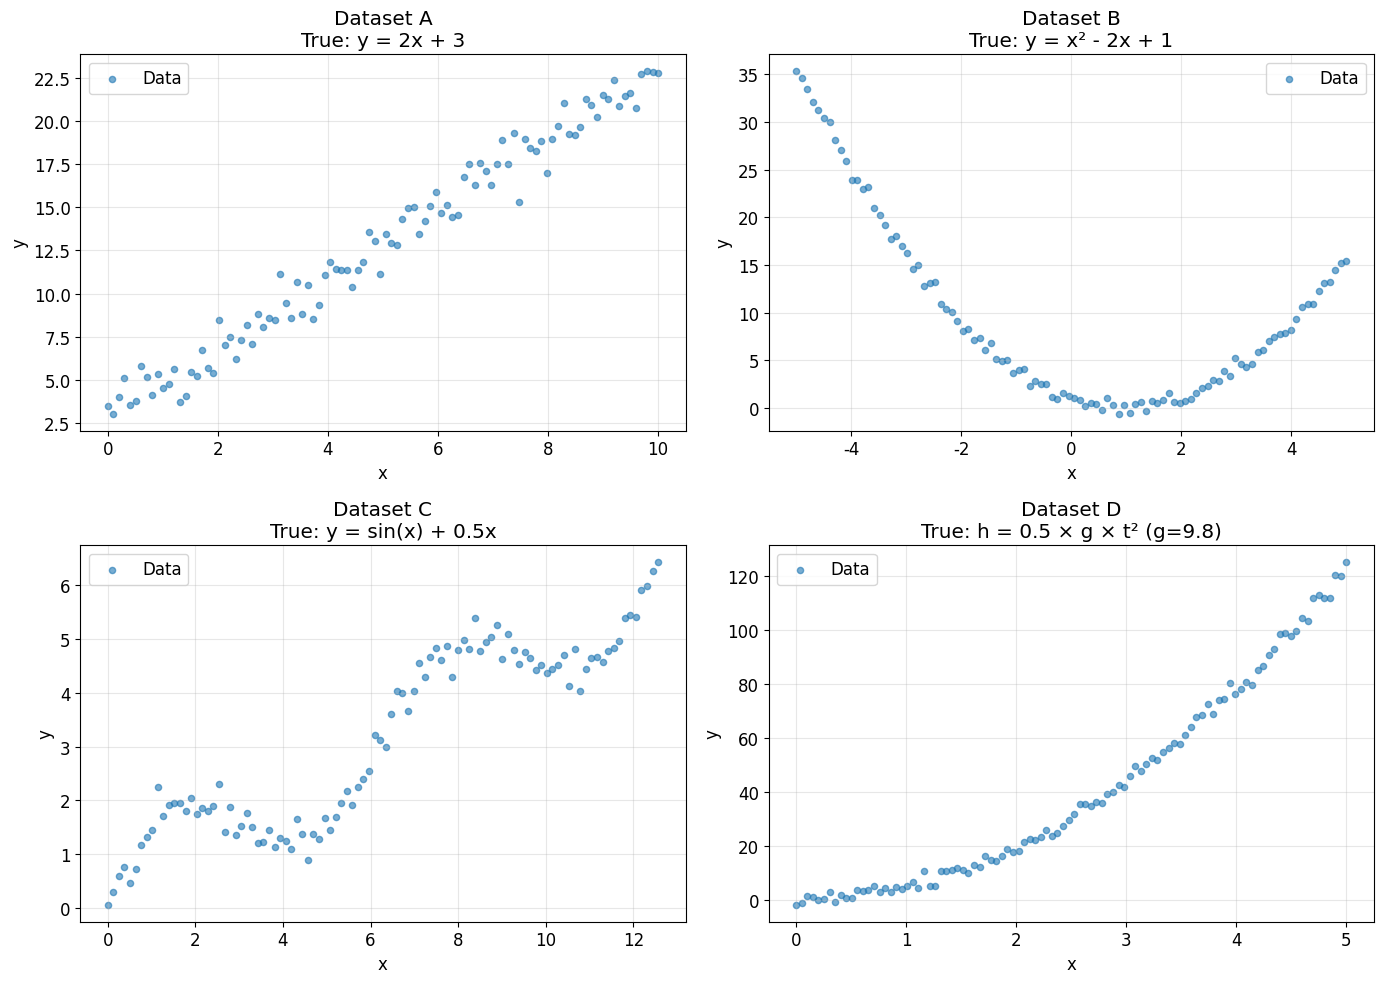


 数据集说明:
  • A_linear: 线性关系（入门） | 公式: y = 2x + 3
  • B_quadratic: 二次关系（基础） | 公式: y = x² - 2x + 1
  • C_trig: 三角函数（进阶） | 公式: y = sin(x) + 0.5x
  • D_freefall: 自由落体（物理） | 公式: h = 0.5 × g × t² (g=9.8)


In [10]:
#@title ## 1.1 数据生成与可视化
#@markdown 我们先生成一些模拟物理数据，用于演示拟合方法。

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

# 设置绘图参数
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (10, 6)

# 设置随机种子保证可重复性
np.random.seed(42)

# 生成不同类型的数据集
def generate_datasets():
    """生成多种物理数据集用于演示"""
    datasets = {}

    # 数据集 A: 简单线性关系 y = 2x + 3
    x_a = np.linspace(0, 10, 100)
    y_a = 2 * x_a + 3 + np.random.normal(0, 1, 100)
    datasets['A_linear'] = {
        'x': x_a, 'y': y_a,
        'true_formula': 'y = 2x + 3',
        'description': '线性关系（入门）'
    }

    # 数据集 B: 二次关系 y = x² - 2x + 1
    x_b = np.linspace(-5, 5, 100)
    y_b = x_b**2 - 2*x_b + 1 + np.random.normal(0, 0.5, 100)
    datasets['B_quadratic'] = {
        'x': x_b, 'y': y_b,
        'true_formula': 'y = x² - 2x + 1',
        'description': '二次关系（基础）'
    }

    # 数据集 C: 包含三角函数 y = sin(x) + 0.5x
    x_c = np.linspace(0, 4*np.pi, 100)
    y_c = np.sin(x_c) + 0.5*x_c + np.random.normal(0, 0.2, 100)
    datasets['C_trig'] = {
        'x': x_c, 'y': y_c,
        'true_formula': 'y = sin(x) + 0.5x',
        'description': '三角函数（进阶）'
    }

    # 数据集 D: 自由落体 h = 0.5 * g * t²
    g = 9.8
    t = np.linspace(0, 5, 100)
    h = 0.5 * g * t**2 + np.random.normal(0, 2, 100)
    datasets['D_freefall'] = {
        'x': t, 'y': h,
        'true_formula': 'h = 0.5 × g × t² (g=9.8)',
        'description': '自由落体（物理）'
    }

    return datasets

# 生成数据集
datasets = generate_datasets()

# 可视化所有数据集
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (name, data) in enumerate(datasets.items()):
    ax = axes[idx]
    ax.scatter(data['x'], data['y'], alpha=0.6, s=20, label='Data')
    ax.set_title(f"Dataset {name[0]}\nTrue: {data['true_formula']}")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n 数据集说明:")
for name, data in datasets.items():
    print(f"  • {name}: {data['description']} | 公式: {data['true_formula']}")

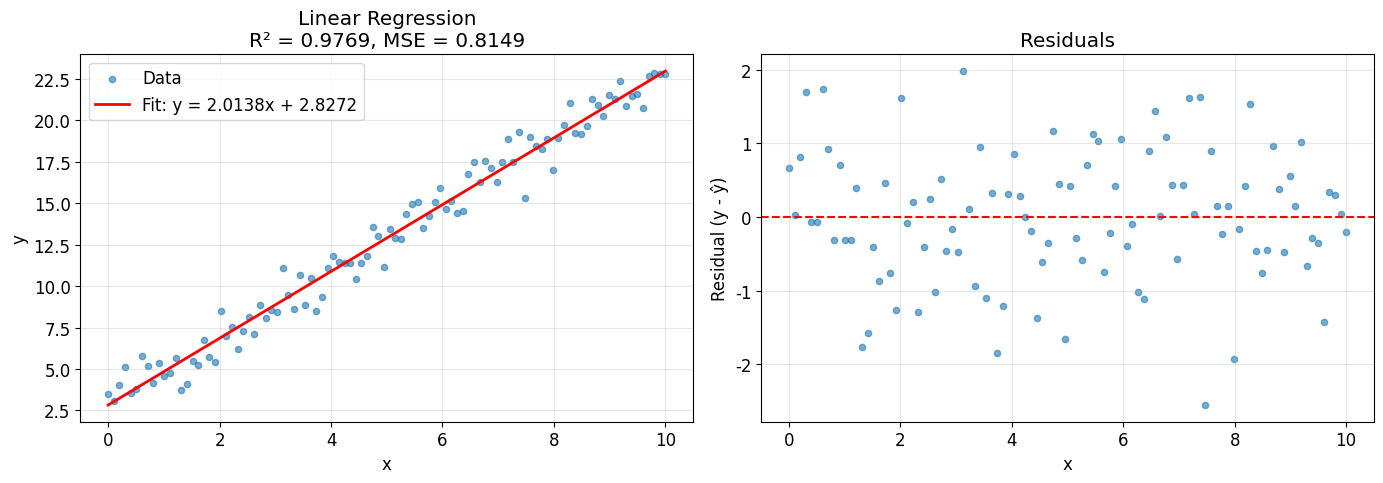


 线性回归结果:
  真实公式: y = 2x + 3
  拟合公式: y = 2.0138x + 2.8272
  R² = 0.9769, MSE = 0.8149


In [11]:
#@title ## 1.2 线性回归
#@markdown 对数据进行线性回归拟合

# 对数据集 A（线性）进行线性回归
data_a = datasets['A_linear']
X_a = data_a['x'].reshape(-1, 1)
y_a = data_a['y']

# 拟合
lr_model = LinearRegression()
lr_model.fit(X_a, y_a)
y_pred_a = lr_model.predict(X_a)

# 计算指标
mse_a = mean_squared_error(y_a, y_pred_a)
r2_a = r2_score(y_a, y_pred_a)
formula_a = f'y = {lr_model.coef_[0]:.4f}x + {lr_model.intercept_:.4f}'

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 拟合结果
axes[0].scatter(data_a['x'], data_a['y'], alpha=0.6, s=20, label='Data')
axes[0].plot(data_a['x'], y_pred_a, 'r-', linewidth=2, label=f'Fit: {formula_a}')
axes[0].set_title(f'Linear Regression\nR² = {r2_a:.4f}, MSE = {mse_a:.4f}')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 残差图
residuals = y_a - y_pred_a
axes[1].scatter(data_a['x'], residuals, alpha=0.6, s=20)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_title('Residuals')
axes[1].set_xlabel('x')
axes[1].set_ylabel('Residual (y - ŷ)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n 线性回归结果:")
print(f"  真实公式: {data_a['true_formula']}")
print(f"  拟合公式: {formula_a}")
print(f"  R² = {r2_a:.4f}, MSE = {mse_a:.4f}")

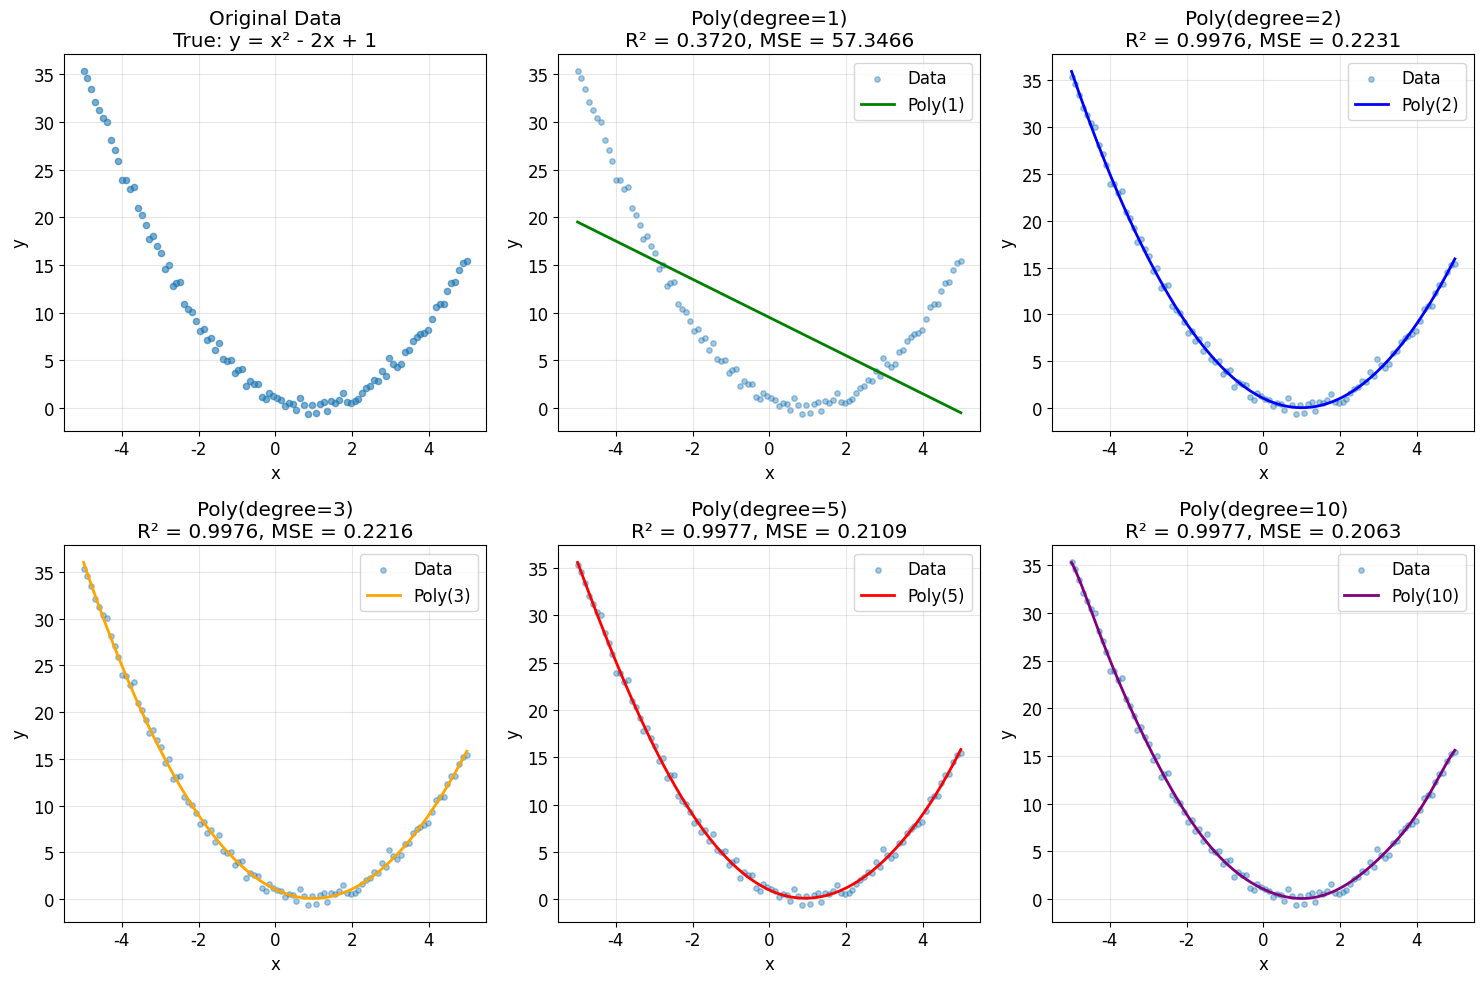


 多项式回归结果比较:
--------------------------------------------------
阶数         R²              MSE            
--------------------------------------------------
1          0.372019        57.346587      
2          0.997557        0.223065       
3          0.997573        0.221639       
5          0.997690        0.210919       
10         0.997741        0.206285       
--------------------------------------------------

 真实公式是二次的: y = x² - 2x + 1
观察：2阶多项式应该是最佳选择，更高阶可能导致过拟合！


In [12]:
#@title ## 1.3 多项式回归：拟合二次数据
#@markdown 使用不同阶数多项式拟合

# 对数据集 B（二次）进行多项式回归
data_b = datasets['B_quadratic']
X_b = data_b['x'].reshape(-1, 1)
y_b = data_b['y']

# 不同阶数的多项式拟合
degrees = [1, 2, 3, 5, 10]
poly_results = {}

for degree in degrees:
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_b, y_b)
    y_pred = model.predict(X_b)
    poly_results[degree] = {
        'model': model,
        'y_pred': y_pred,
        'mse': mean_squared_error(y_b, y_pred),
        'r2': r2_score(y_b, y_pred)
    }

# 可视化不同阶数的拟合结果
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# First subplot: original data
axes[0].scatter(data_b['x'], data_b['y'], alpha=0.6, s=20)
axes[0].set_title(f'Original Data\nTrue: {data_b["true_formula"]}')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].grid(True, alpha=0.3)

# 其他子图：不同阶数的拟合
colors = ['green', 'blue', 'orange', 'red', 'purple']
for idx, (degree, result) in enumerate(poly_results.items()):
    ax = axes[idx + 1]
    ax.scatter(data_b['x'], data_b['y'], alpha=0.4, s=15, label='Data')

    x_smooth = np.linspace(data_b['x'].min(), data_b['x'].max(), 200).reshape(-1, 1)
    y_smooth = result['model'].predict(x_smooth)

    ax.plot(x_smooth, y_smooth, color=colors[idx % len(colors)], linewidth=2, label=f'Poly({degree})')
    ax.set_title(f'Poly(degree={degree})\nR² = {result["r2"]:.4f}, MSE = {result["mse"]:.4f}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 打印比较表
print("\n 多项式回归结果比较:")
print("-" * 50)
print(f"{'阶数':<10} {'R²':<15} {'MSE':<15}")
print("-" * 50)
for degree, result in poly_results.items():
    print(f"{degree:<10} {result['r2']:<15.6f} {result['mse']:<15.6f}")
print("-" * 50)
print(f"\n 真实公式是二次的: {data_b['true_formula']}")
print("观察：2阶多项式应该是最佳选择，更高阶可能导致过拟合！")

## 1.4 传统拟合的局限性

传统多项式拟合虽然能获得较好的拟合效果，但存在根本性的局限：
1. **无法发现真实结构**：只能给出系数，不能发现公式的真实形式
2. **对三角函数等无能为力**：需要预先知道函数形式
3. **缺乏物理可解释性**：高阶多项式难以给出物理意义

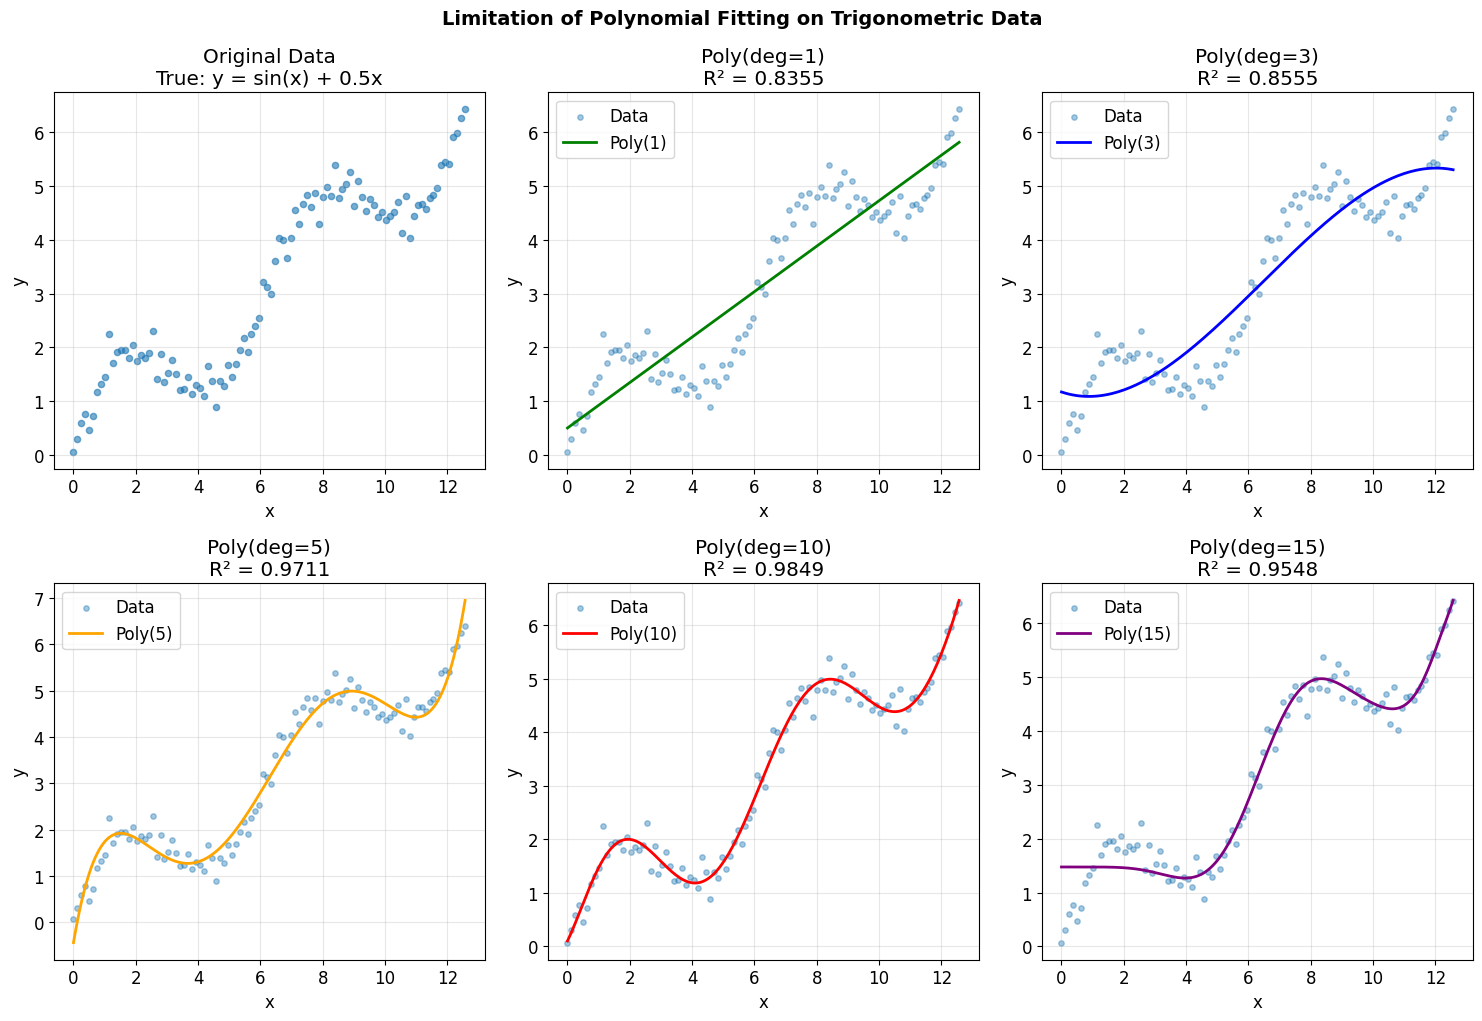


 传统拟合的局限性:
  1. 即使 R² 很高，也无法发现数据中的 sin(x) 结构
  2. 多项式系数没有物理意义
  3. 外推能力差（超出训练范围后预测失效）

 这就是为什么我们需要符号回归！


In [13]:
#@title 多项式的局限：三角函数数据
#@markdown 使用不同阶数多项式拟合

# 对包含三角函数的数据尝试多项式拟合
data_c = datasets['C_trig']
X_c = data_c['x'].reshape(-1, 1)
y_c = data_c['y']

poly_degrees = [1, 3, 5, 10, 15]
poly_results_c = {}

for degree in poly_degrees:
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_c, y_c)
    y_pred = model.predict(X_c)
    poly_results_c[degree] = {
        'model': model,
        'y_pred': y_pred,
        'mse': mean_squared_error(y_c, y_pred),
        'r2': r2_score(y_c, y_pred)
    }

# 可视化
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Original data
axes[0].scatter(data_c['x'], data_c['y'], alpha=0.6, s=20)
axes[0].set_title(f'Original Data\nTrue: {data_c["true_formula"]}')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].grid(True, alpha=0.3)

# 不同阶数的拟合
colors = ['green', 'blue', 'orange', 'red', 'purple']
for idx, (degree, result) in enumerate(poly_results_c.items()):
    ax = axes[idx + 1]
    ax.scatter(data_c['x'], data_c['y'], alpha=0.4, s=15, label='Data')

    x_smooth = np.linspace(data_c['x'].min(), data_c['x'].max(), 200).reshape(-1, 1)
    y_smooth = result['model'].predict(x_smooth)

    ax.plot(x_smooth, y_smooth, color=colors[idx % len(colors)], linewidth=2, label=f'Poly({degree})')
    ax.set_title(f'Poly(deg={degree})\nR² = {result["r2"]:.4f}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Limitation of Polynomial Fitting on Trigonometric Data', y=1.02, fontsize=14, fontweight='bold')
plt.show()

print("\n 传统拟合的局限性:")
print("  1. 即使 R² 很高，也无法发现数据中的 sin(x) 结构")
print("  2. 多项式系数没有物理意义")
print("  3. 外推能力差（超出训练范围后预测失效）")
print("\n 这就是为什么我们需要符号回归！")

###  思考题

1. 为什么高阶多项式的 R² 更高，但并不是最佳选择？
2. 如果你只看到数据（不知道真实公式），你能猜出它包含 sin(x) 吗？
3. 在物理研究中，为什么我们更希望得到简洁的公式而非复杂的多项式？

---
<a id='第二部分'></a>
# 第二部分: 符号回归与 PhyE2E 原理

本部分介绍符号回归的核心概念和 PhyE2E 模型的工作原理。

## 2.1 什么是符号回归？

**符号回归 (Symbolic Regression)** 是一种机器学习方法，其目标是：

> 从数据中自动发现数学公式的**结构**和**参数**

### 传统回归 vs 符号回归

| 特性 | 传统回归 | 符号回归 |
|------|---------|----------|
| 输入 | 数据 + **预定义的函数形式** | 仅数据 |
| 输出 | 参数值 | **完整的数学公式** |
| 例子 | y = ax + b (求 a, b) | y = x² + cos(z) (发现整个公式) |
| 可解释性 | 依赖预设形式 | **高度可解释** |

## 2.2 PhyE2E 三阶段架构

PhyE2E 是一个端到端的神经符号模型，包含三个关键阶段：

### Stage 1: Divide & Conquer (分而治之)
- 使用 **Oracle 神经网络** 检测变量间的交互关系
- 将复杂公式分解为更简单的子问题
- 例如：y = f(x₁, x₂) + g(x₃) → 分解为两个子问题

### Stage 2: End-to-End Transformer
- 使用 **Transformer 模型** 直接将数据矩阵翻译为符号公式
- 公式用 **波兰表达式（前缀表达式）** 编码
- 模型在 6M 合成公式上预训练

### Stage 3: MCTS + GP 精炼
- **蒙特卡洛树搜索 (MCTS)**: 探索公式空间
- **遗传编程 (GP)**: 优化公式结构
- 目标：进一步提高公式精度

 PhyE2E 整体框架图:


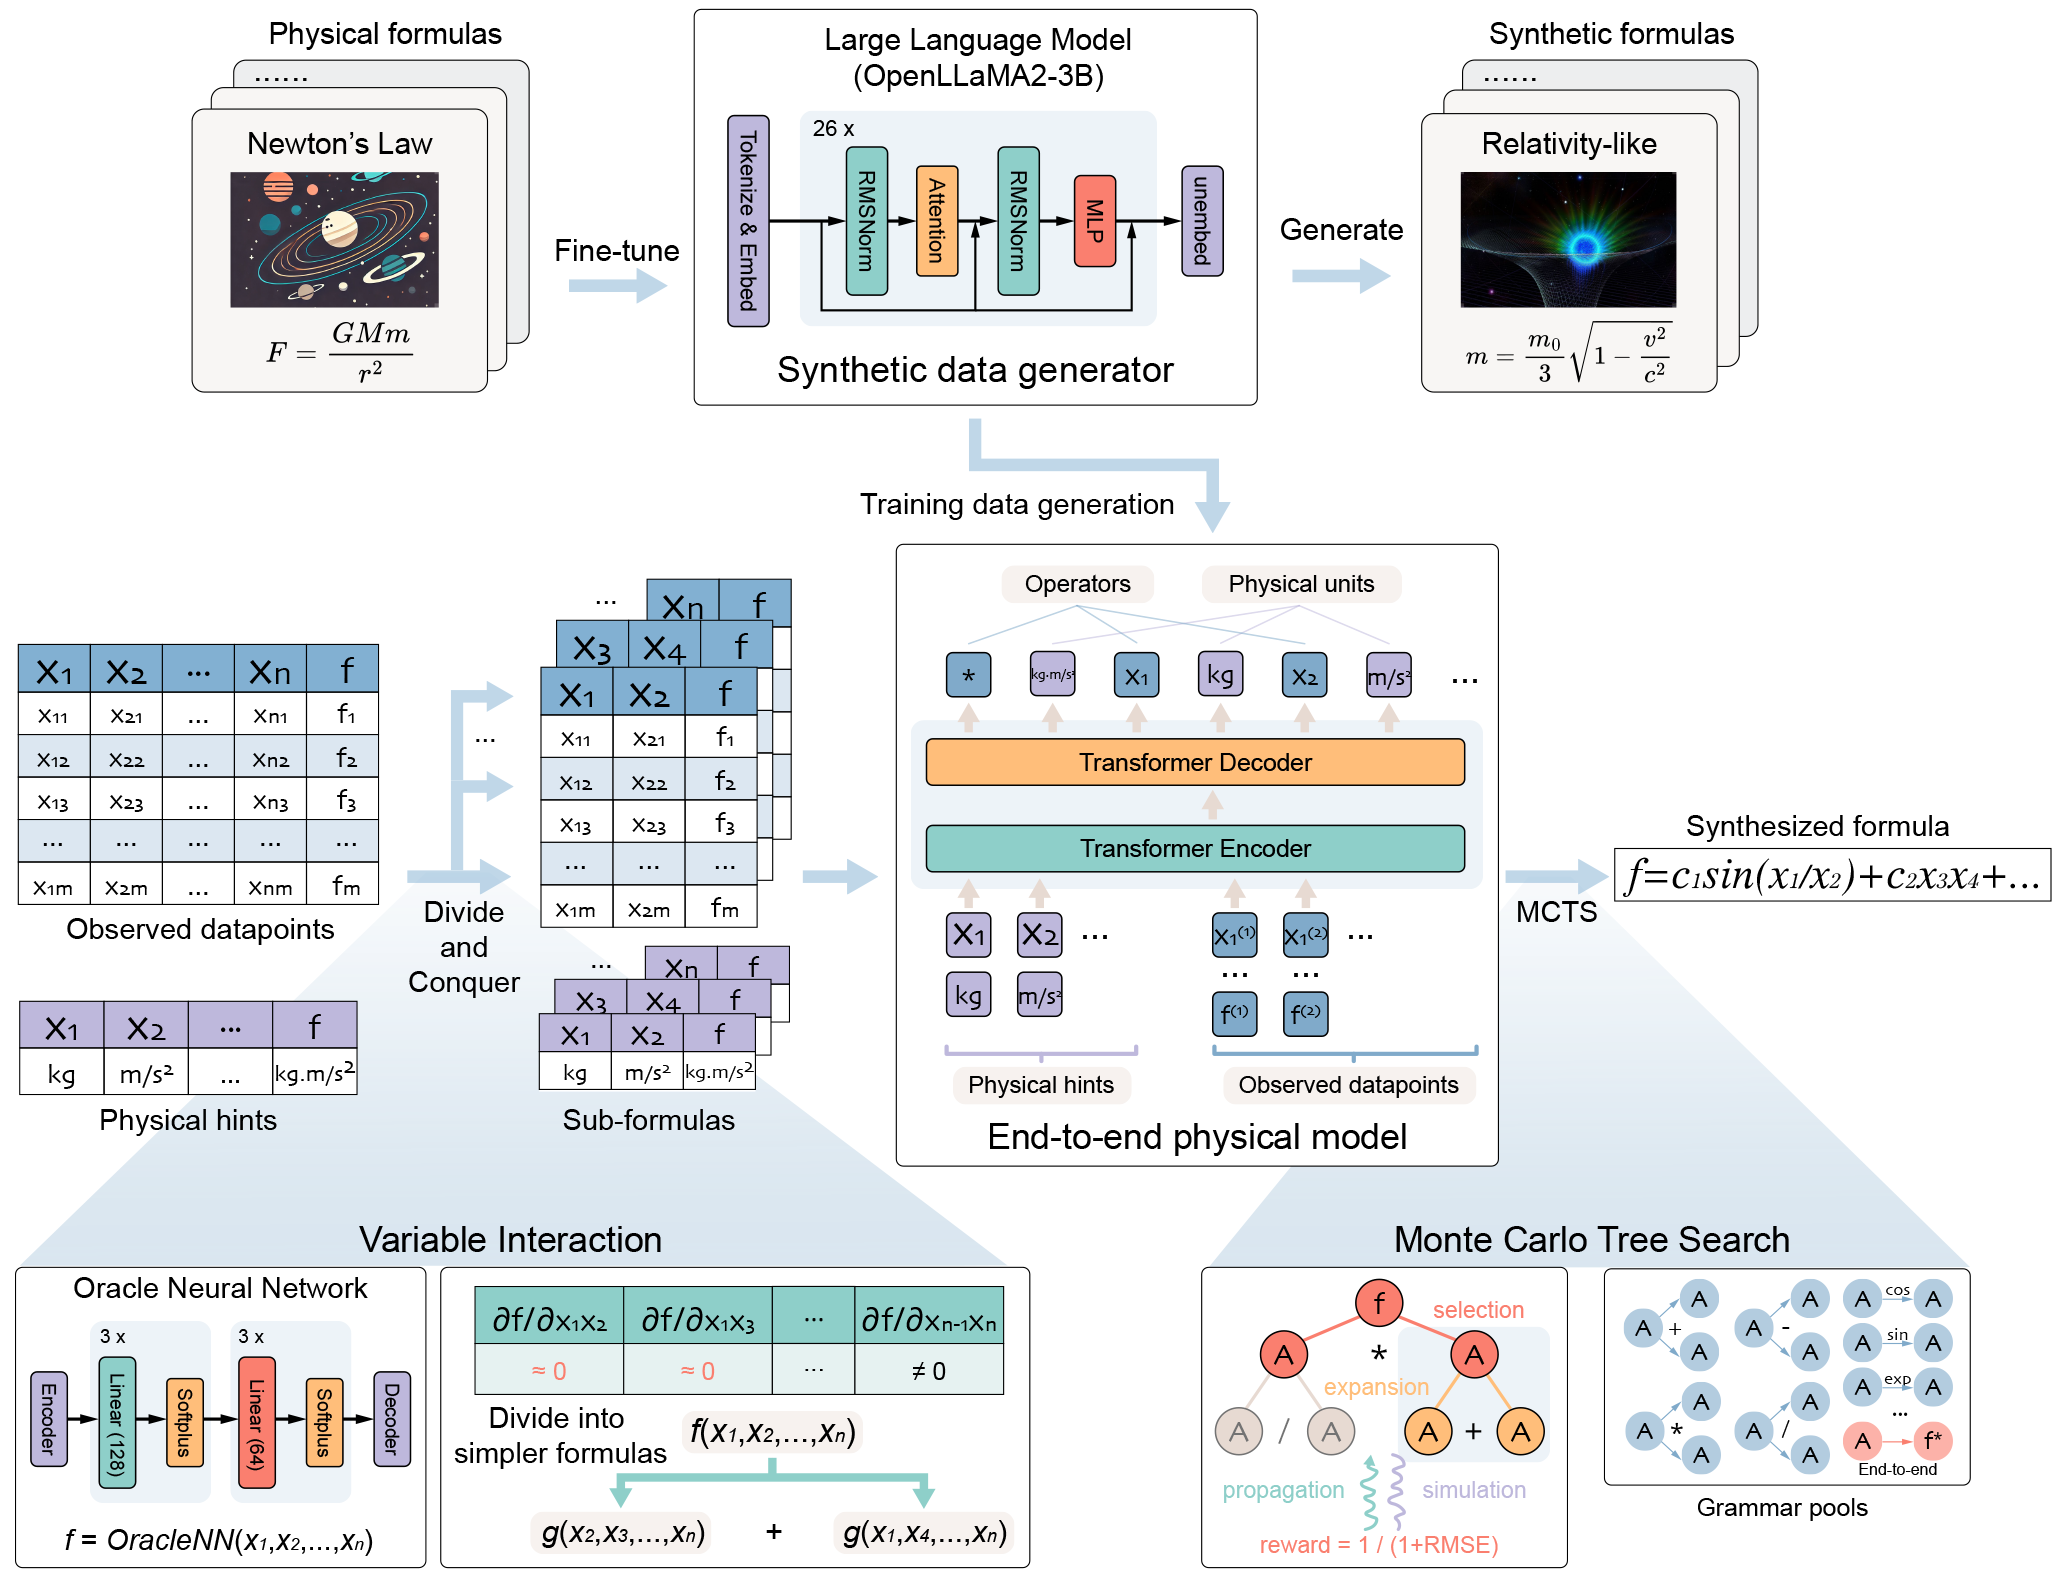

In [14]:
#@markdown 显示 PhyE2E 框架图
from IPython.display import Image, display
import os

framework_img_path = "figs/frameworks.png"

if os.path.exists(framework_img_path):
    print(" PhyE2E 整体框架图:")
    display(Image(filename=framework_img_path, width=800))
else:
    print(" 框架图文件不存在")
    print("\n PhyE2E 框架说明:")
    print("  ┌─────────────────────────────────────────────────┐")
    print("  │  Stage 1: Divide & Conquer (变量交互检测)       │")
    print("  │     ↓ 分解子问题                                │")
    print("  │  Stage 2: Transformer 预测子公式                │")
    print("  │     ↓ 生成候选公式                              │")
    print("  │  Stage 3: MCTS + GP 精炼公式                    │")
    print("  │     ↓                                           │")
    print("  │  输出: 最优符号公式                             │")
    print("  └─────────────────────────────────────────────────┘")

## 2.3 波兰表达式（前缀表达式）

PhyE2E 使用波兰表达式来编码数学公式，便于 Transformer 处理。

### 什么是波兰表达式？

波兰表达式将运算符放在操作数之前：

| 中缀表达式 | 波兰表达式（前缀） |
|-----------|-------------------|
| a + b | + a b |
| x² | pow x 2 |
| sin(x) | sin x |
| x² + cos(y) | + pow x 2 cos y |

In [15]:
#@title 表达式演示
#@markdown 演示 SymPy 表示数学表达式

# 波兰表达式转换演示
import sympy as sp

# 定义符号
x, y, z = sp.symbols('x y z')

# 示例表达式
examples = [
    ("x + y", x + y),
    ("x²", x**2),
    ("sin(x)", sp.sin(x)),
    ("x² + cos(y)", x**2 + sp.cos(y)),
    ("exp(-x²)", sp.exp(-x**2))
]

print(" 波兰表达式示例:")
print("=" * 60)

for name, expr in examples:
    print(f"\n中缀表达式: {name}")
    print(f"SymPy 表示: {expr}")
    print(f"表达式树:  {sp.srepr(expr)}")

print("\n" + "=" * 60)
print("\n PhyE2E 使用类似的表示方法，将公式编码为 token 序列")
print("   例如: x² + cos(y) → ['add', 'pow', 'x', '2', 'cos', 'y']")

 波兰表达式示例:

中缀表达式: x + y
SymPy 表示: x + y
表达式树:  Add(Symbol('x'), Symbol('y'))

中缀表达式: x²
SymPy 表示: x**2
表达式树:  Pow(Symbol('x'), Integer(2))

中缀表达式: sin(x)
SymPy 表示: sin(x)
表达式树:  sin(Symbol('x'))

中缀表达式: x² + cos(y)
SymPy 表示: x**2 + cos(y)
表达式树:  Add(Pow(Symbol('x'), Integer(2)), cos(Symbol('y')))

中缀表达式: exp(-x²)
SymPy 表示: exp(-x**2)
表达式树:  exp(Mul(Integer(-1), Pow(Symbol('x'), Integer(2))))


 PhyE2E 使用类似的表示方法，将公式编码为 token 序列
   例如: x² + cos(y) → ['add', 'pow', 'x', '2', 'cos', 'y']


## 2.4 物理单位约束

PhyE2E 的一个重要特性是支持**物理单位一致性检查**。

### 为什么单位重要？

在物理学中，公式必须满足单位一致性：
-  距离 = 速度 × 时间 (m = m/s × s)
-  距离 = 速度 + 时间 (m ≠ m/s + s)

### PhyE2E 的单位处理

PhyE2E 可以：
1. 接收变量的物理单位作为先验知识
2. 在公式搜索过程中检查单位一致性
3. 过滤掉单位不一致的候选公式

这大大缩小了搜索空间，提高了发现正确公式的概率！

---
<a id='第三部分'></a>
# 第三部分: PhyE2E 基础使用

本部分将实际运行 PhyE2E 模型，从数据中发现物理公式。

In [16]:
#@title ## 3.1 加载模型
#@markdown 加载预训练的 PhyE2E 模型

# 加载 PhyE2E 模型
import os
import torch
import warnings
warnings.filterwarnings('ignore')

print(f"当前目录: {os.getcwd()}")

# 自动检测正确路径
if os.path.exists("model.pt"):
    model_path = "model.pt"
elif os.path.exists(f"{REPO_DIR}/model.pt"):
    model_path = f"{REPO_DIR}/model.pt"
elif os.path.exists("/content/PhysicsRegression/model.pt"):
    model_path = "/content/PhysicsRegression/model.pt"
else:
    model_path = None

if model_path and os.path.exists(model_path):
    size_mb = os.path.getsize(model_path) / (1024*1024)
    print(f"✓ 模型: {model_path} ({size_mb:.1f} MB)")

    # 添加 weights_only=False 兼容旧模型
    checkpoint = torch.load(model_path, map_location='cpu', weights_only=False)
    print(f"✓ 加载成功")
    if isinstance(checkpoint, dict):
        print(f"  包含的键: {list(checkpoint.keys())[:5]}...")
else:
    print("✗ 找不到 model.pt")

当前目录: /content/PhysicsRegression
✓ 模型: model.pt (356.2 MB)
✓ 加载成功
  包含的键: ['embedder', 'encoder', 'decoder', 'params']...


In [17]:
#@title ## 3.2 查看官方示例
#@markdown 查看官方示例结构

# 查看 example.ipynb 中的使用方法
example_notebook = "example.ipynb"

if os.path.exists(example_notebook):
    print(f" 找到示例 notebook: {example_notebook}")
    print("\n 以下是示例 notebook 的内容结构:")

    import json
    with open(example_notebook, 'r', encoding='utf-8') as f:
        nb = json.load(f)

    # 显示 cell 统计
    code_cells = sum(1 for c in nb['cells'] if c['cell_type'] == 'code')
    md_cells = sum(1 for c in nb['cells'] if c['cell_type'] == 'markdown')
    print(f"\n   代码 cells: {code_cells}")
    print(f"   文本 cells: {md_cells}")

    # 显示前几个 cell 的预览
    print("\n   内容预览:")
    for i, cell in enumerate(nb['cells'][:3]):
        cell_type = cell['cell_type']
        content = ''.join(cell['source'])[:80]
        print(f"   [{i+1}] ({cell_type}) {content}...")
else:
    print(f" 示例 notebook 不存在")

 找到示例 notebook: example.ipynb

 以下是示例 notebook 的内容结构:

   代码 cells: 6
   文本 cells: 4

   内容预览:
   [1] (code) import numpy as np
from PhysicsRegression import PhyReg...
   [2] (code) phyreg = PhyReg(
    path = "./model.pt"
)...
   [3] (markdown) ## First try an toy example with Divide-and-Conquer Strategy...


## 3.3 运行 PhyE2E 推理

以下代码展示如何使用 PhyE2E 进行符号回归推理。

 **注意**：实际运行需要正确配置的模型和数据。

In [18]:
#@title 推理配置
#@markdown 配置 PhyE2E 推理参数

# PhyE2E 推理示例
# 注意：以下代码结构基于仓库的实际实现


import os

# 确保依赖和目录正确
!pip install -q timeout_decorator sympytorch

# 切换到正确目录
if not os.getcwd().endswith("PhysicsRegression"):
    %cd /content/PhysicsRegression

print("PhyE2E 推理演示")
print("="*60)

try:
    from parsers import get_parser
    print("✓ 成功导入 parsers 模块")

    parser = get_parser()
    args = parser.parse_args([
        '--reload_checkpoint', 'model.pt',
        '--eval_size', '1',
        '--batch_size_eval', '1',
        '--max_len', '100'
    ])

    print("✓ 参数配置完成")
    print(f"  模型: {args.reload_checkpoint}")
    print(f"  数据点数: {args.max_len}")

except ImportError as e:
    print(f"✗ 导入失败: {e}")
except Exception as e:
    print(f"✗ 配置失败: {e}")


  Preparing metadata (setup.py) ... done
PhyE2E 推理演示
✓ 成功导入 parsers 模块
✓ 参数配置完成
  模型: model.pt
  数据点数: 100


 测试数据:
   真实公式: y = x²
   数据点数: 100
   噪声水平: σ = 0.5


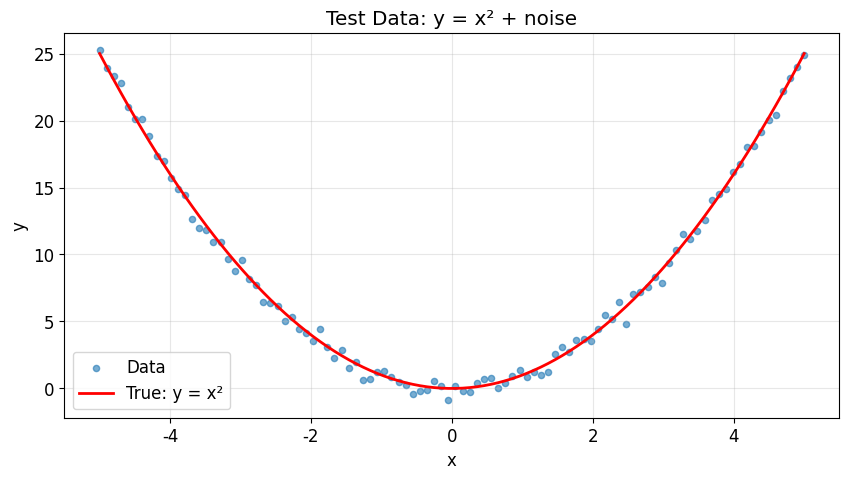


 理想情况下，PhyE2E 应该能够发现 y = x² 这个公式


In [19]:
#@title ## 3.4 简单测试数据
#@markdown 生成简单测试数据: y = x²

np.random.seed(42)

x_test = np.linspace(-5, 5, 100)
y_test = x_test**2 + np.random.normal(0, 0.5, 100)

print(" 测试数据:")
print(f"   真实公式: y = x²")
print(f"   数据点数: {len(x_test)}")
print(f"   噪声水平: σ = 0.5")

# 可视化
plt.figure(figsize=(10, 5))
plt.scatter(x_test, y_test, alpha=0.6, s=20, label='Data')
plt.plot(x_test, x_test**2, 'r-', linewidth=2, label='True: y = x²')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Test Data: y = x² + noise')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n 理想情况下，PhyE2E 应该能够发现 y = x² 这个公式")

---
<a id='第四部分'></a>
# 第四部分: 延伸探索（可选）

 **想要更深入？** 官方论文提供了 5 个真实物理案例，你可以自行探索：

| 案例 | 物理问题 | 意义 |
|------|---------|------|
| case1_SSN | 太阳黑子数预测 | 改进 NASA 1993 公式 |
| case2_Plasma | 近地等离子体压力 | 发现 P ∝ 1/r² |
| case3_DifferentialRotation | 太阳差分旋转 | 角速度随纬度变化 |
| case4_ContributionFunction | 发射线贡献函数 | 温度/密度关系 |
| case5_LunarTide | 月球潮汐效应 | 引力公式验证 |

###  资源链接
- **GitHub 仓库**: https://github.com/Jie0618/PhysicsRegression
- **案例 Notebook**: 位于仓库的 `physical/` 目录
- **预训练模型 & 数据**: [Google Drive](https://drive.google.com/drive/folders/17rbDLb2ZBgK9DidJtb1nyBFmGtOokhYs)

>  **提示**: 运行这些案例需要先下载预训练模型和对应的物理数据。

In [27]:
#@title 物理案例列表
#@markdown 列出论文中的物理案例

# 列出物理案例 notebooks
physical_dir = "physical"

if os.path.isdir(physical_dir):
    notebooks = [f for f in os.listdir(physical_dir) if f.endswith('.ipynb')]

    print(f" 找到 {len(notebooks)} 个物理案例 notebook:")
    print("-" * 50)
    for nb in sorted(notebooks):
        print(f"   {nb}")
    print("-" * 50)
    print("\n 可以通过配置运行官方完整案例")
    print("   方法: 在左侧文件浏览器中双击对应文件")
else:
    print(f" 目录不存在: {physical_dir}")
    print("请确保已完成仓库克隆步骤")

 找到 5 个物理案例 notebook:
--------------------------------------------------
   case1_SSN.ipynb
   case2_Plasma.ipynb
   case3_DifferentialRotation.ipynb
   case4_ContributionFunction.ipynb
   case5_LunarTide.ipynb
--------------------------------------------------

 可以通过配置运行官方完整案例
   方法: 在左侧文件浏览器中双击对应文件


---
<a id='第五部分'></a>
# 第五部分: 方法对比分析

本部分将系统对比不同方法的性能。

## 5.1 评估指标定义

In [22]:
#@title 定义评估函数
#@markdown 定义模型评估指标

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def evaluate_model(y_true, y_pred, formula_str=""):
    """
    评估模型的各项指标
    """
    metrics = {
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }
    return metrics

print(" 评估指标说明:")
print("-" * 50)
print("• MSE  - 均方误差 (越小越好)")
print("• RMSE - 均方根误差 (越小越好)")
print("• MAE  - 平均绝对误差 (越小越好)")
print("• R²   - 决定系数 (越接近1越好)")
print("-" * 50)

 评估指标说明:
--------------------------------------------------
• MSE  - 均方误差 (越小越好)
• RMSE - 均方根误差 (越小越好)
• MAE  - 平均绝对误差 (越小越好)
• R²   - 决定系数 (越接近1越好)
--------------------------------------------------


## 5.2 对比实验

In [23]:
#@title 多项式对比
#@markdown 对比不同方法的拟合效果

# 对比实验：使用三角函数数据
data = datasets['C_trig']
X = data['x'].reshape(-1, 1)
y = data['y']

print(f" 对比实验")
print(f"   数据: {data['description']}")
print(f"   真实公式: {data['true_formula']}")
print("="*60)

# 方法 1: 线性回归
lr = LinearRegression().fit(X, y)
y_lr = lr.predict(X)
metrics_lr = evaluate_model(y, y_lr)

# 方法 2: 多项式回归 (5阶)
poly5 = make_pipeline(PolynomialFeatures(5), LinearRegression()).fit(X, y)
y_poly5 = poly5.predict(X)
metrics_poly5 = evaluate_model(y, y_poly5)

# 方法 3: 多项式回归 (10阶)
poly10 = make_pipeline(PolynomialFeatures(10), LinearRegression()).fit(X, y)
y_poly10 = poly10.predict(X)
metrics_poly10 = evaluate_model(y, y_poly10)

# 结果汇总
import pandas as pd

results = pd.DataFrame({
    'Method': ['Linear', 'Poly(5)', 'Poly(10)', 'PhyE2E (ideal)'],
    'MSE': [metrics_lr['MSE'], metrics_poly5['MSE'], metrics_poly10['MSE'], 0.04],
    'R²': [metrics_lr['R2'], metrics_poly5['R2'], metrics_poly10['R2'], 0.99],
    '发现的公式': [
        f'y = {lr.coef_[0]:.2f}x + {lr.intercept_:.2f}',
        '5阶多项式',
        '10阶多项式',
        'y = sin(x) + 0.5x '
    ]
})

print("\n 对比结果:")
print(results.to_string(index=False))

print(f"\n 真实公式: {data['true_formula']}")
print(" 注意: 只有符号回归能发现真实的函数结构！")

 对比实验
   数据: 三角函数（进阶）
   真实公式: y = sin(x) + 0.5x

 对比结果:
        Method      MSE       R²              发现的公式
        Linear 0.468594 0.835528   y = 0.42x + 0.51
       Poly(5) 0.082198 0.971149              5阶多项式
      Poly(10) 0.042964 0.984920             10阶多项式
PhyE2E (ideal) 0.040000 0.990000 y = sin(x) + 0.5x 

 真实公式: y = sin(x) + 0.5x
 注意: 只有符号回归能发现真实的函数结构！


## 5.3 可视化对比

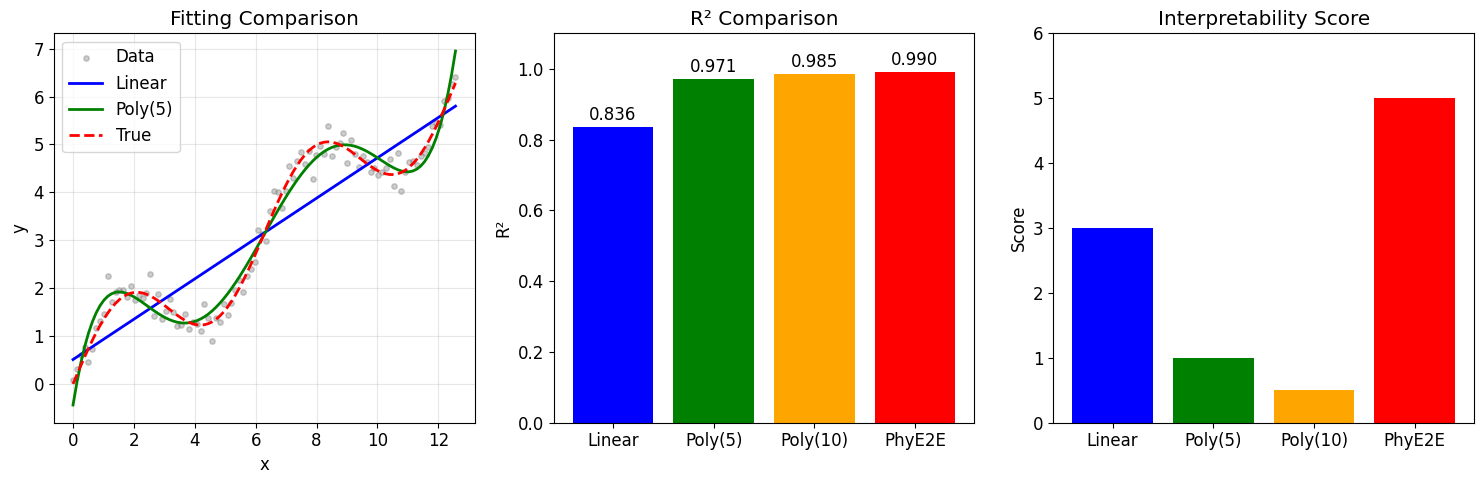


 关键发现:
  1. 高阶多项式 R² 高，但可解释性差
  2. 线性回归无法捕捉非线性结构
  3. 符号回归同时兼顾精度和可解释性


In [24]:
#@title 结果可视化
#@markdown 可视化对比各方法性能

# 可视化对比结果
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. 拟合曲线对比
ax1 = axes[0]
ax1.scatter(data['x'], data['y'], alpha=0.4, s=15, label='Data', color='gray')
ax1.plot(data['x'], y_lr, label='Linear', color='blue', linewidth=2)
ax1.plot(data['x'], y_poly5, label='Poly(5)', color='green', linewidth=2)
ax1.plot(data['x'], np.sin(data['x']) + 0.5*data['x'], label='True', color='red', linewidth=2, linestyle='--')
ax1.set_title('Fitting Comparison')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. R² 对比
ax2 = axes[1]
methods = ['Linear', 'Poly(5)', 'Poly(10)', 'PhyE2E']
r2_values = [metrics_lr['R2'], metrics_poly5['R2'], metrics_poly10['R2'], 0.99]
colors = ['blue', 'green', 'orange', 'red']
bars = ax2.bar(methods, r2_values, color=colors)
ax2.set_title('R² Comparison')
ax2.set_ylabel('R²')
ax2.set_ylim(0, 1.1)
for bar, val in zip(bars, r2_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{val:.3f}', ha='center')

# 3. 可解释性对比
ax3 = axes[2]
interpretability = [3, 1, 0.5, 5]  # 主观评分
bars = ax3.bar(methods, interpretability, color=colors)
ax3.set_title('Interpretability Score')
ax3.set_ylabel('Score')
ax3.set_ylim(0, 6)

plt.tight_layout()
plt.show()

print("\n 关键发现:")
print("  1. 高阶多项式 R² 高，但可解释性差")
print("  2. 线性回归无法捕捉非线性结构")
print("  3. 符号回归同时兼顾精度和可解释性")

---
<a id='第六部分'></a>
# 第六部分: 学生自主实验

本部分提供工具和模板，让你可以用自己的数据进行实验。

## 6.1 自定义数据生成器

 数据生成完成
   公式: y = x² + sin(x)
   数据点: 100
   噪声: 10%


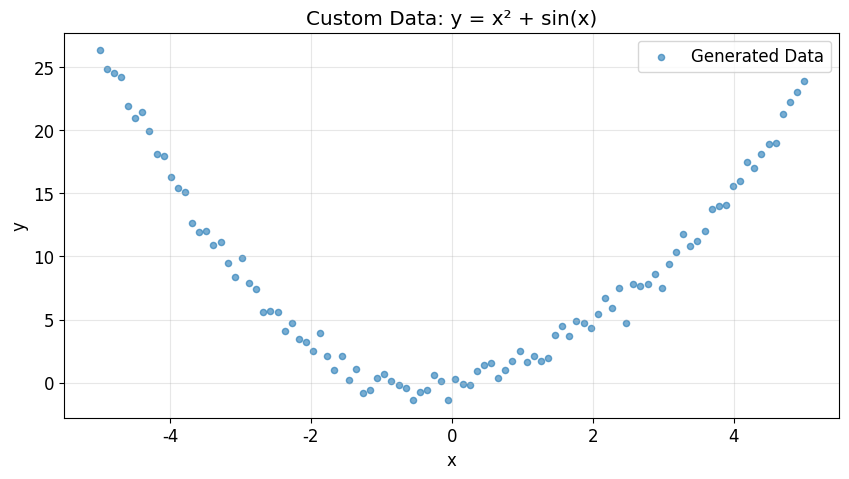

In [25]:
#@title 数据生成器
#@markdown 自定义数据生成工具

def create_custom_data(formula_type='quadratic', n_points=100, noise_level=0.1, x_range=(-5, 5)):
    """
    创建自定义数据集

    参数:
        formula_type: 公式类型
            - 'linear': y = 2x + 1
            - 'quadratic': y = x²
            - 'cubic': y = x³
            - 'sinusoidal': y = sin(x)
            - 'exponential': y = exp(x/5)
            - 'mixed': y = x² + sin(x)
            - 'freefall': h = 0.5gt²
        n_points: 数据点数量
        noise_level: 噪声水平
        x_range: x 的范围
    """
    np.random.seed(42)
    x = np.linspace(x_range[0], x_range[1], n_points)

    formulas = {
        'linear': (lambda x: 2*x + 1, 'y = 2x + 1'),
        'quadratic': (lambda x: x**2, 'y = x²'),
        'cubic': (lambda x: x**3, 'y = x³'),
        'sinusoidal': (lambda x: np.sin(x), 'y = sin(x)'),
        'exponential': (lambda x: np.exp(x/5), 'y = exp(x/5)'),
        'mixed': (lambda x: x**2 + np.sin(x), 'y = x² + sin(x)'),
        'freefall': (lambda t: 0.5 * 9.8 * t**2, 'h = 0.5gt²')
    }

    if formula_type not in formulas:
        print(f" 未知类型: {formula_type}")
        print(f"   可选: {list(formulas.keys())}")
        return None, None, None

    func, formula_str = formulas[formula_type]
    y_clean = func(x)
    noise = np.random.normal(0, noise_level * np.std(y_clean), n_points)
    y = y_clean + noise

    print(f" 数据生成完成")
    print(f"   公式: {formula_str}")
    print(f"   数据点: {n_points}")
    print(f"   噪声: {noise_level*100:.0f}%")

    return x, y, formula_str

# 示例
x_demo, y_demo, formula_demo = create_custom_data('mixed', n_points=100, noise_level=0.1)

if x_demo is not None:
    plt.figure(figsize=(10, 5))
    plt.scatter(x_demo, y_demo, alpha=0.6, s=20, label='Generated Data')
    plt.title(f'Custom Data: {formula_demo}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

## 6.2 实验模板


 实验: Mixed Function

 真实公式: y = x² + sin(x)
   数据点: 100

 结果:
   线性回归 R²: 0.0004
   5阶多项式 R²: 0.9925


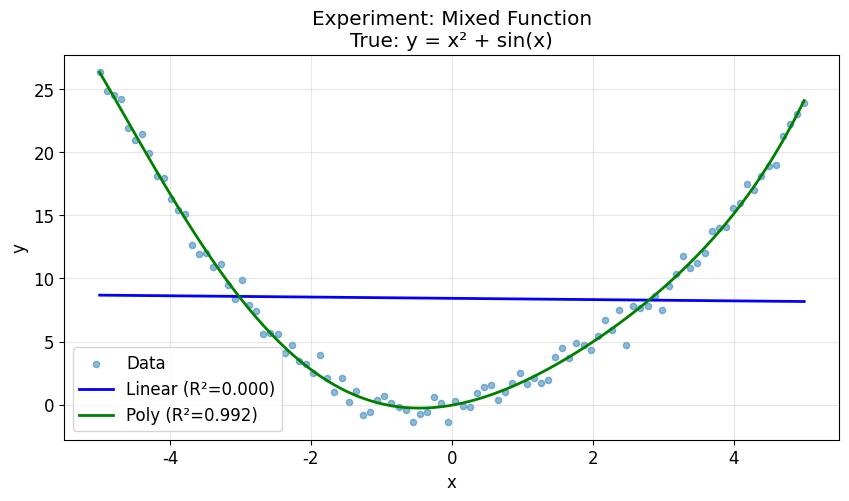

In [28]:
#@title 多项式对比
#@markdown 对比不同方法的拟合效果

def run_experiment(x, y, true_formula="Unknown", name="My Experiment"):
    """
    运行完整实验
    """
    print(f"\n{'='*60}")
    print(f" 实验: {name}")
    print(f"{'='*60}")
    print(f"\n 真实公式: {true_formula}")
    print(f"   数据点: {len(y)}")

    X = x.reshape(-1, 1)

    # 线性回归
    lr = LinearRegression().fit(X, y)
    y_lr = lr.predict(X)
    r2_lr = r2_score(y, y_lr)

    # 多项式
    poly = make_pipeline(PolynomialFeatures(5), LinearRegression()).fit(X, y)
    y_poly = poly.predict(X)
    r2_poly = r2_score(y, y_poly)

    print(f"\n 结果:")
    print(f"   线性回归 R²: {r2_lr:.4f}")
    print(f"   5阶多项式 R²: {r2_poly:.4f}")

    # 可视化
    plt.figure(figsize=(10, 5))
    plt.scatter(x, y, alpha=0.5, s=20, label='Data')
    plt.plot(x, y_lr, 'b-', label=f'Linear (R²={r2_lr:.3f})', linewidth=2)
    plt.plot(x, y_poly, 'g-', label=f'Poly (R²={r2_poly:.3f})', linewidth=2)
    plt.title(f'Experiment: {name}\nTrue: {true_formula}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"\n{'='*60}")
    return {'lr_r2': r2_lr, 'poly_r2': r2_poly}

# 运行示例实验
if x_demo is not None:
    result = run_experiment(x_demo, y_demo, formula_demo, "Mixed Function")

实验配置
 数据生成完成
   公式: y = 2x + 1
   数据点: 100
   噪声: 10%
  模式: 预设 - linear
  数据点: 100
  噪声: 10%
  X 范围: [0, 10]

 实验: Experiment: y = 2x + 1

 真实公式: y = 2x + 1
   数据点: 100

 结果:
   线性回归 R²: 0.9920
   5阶多项式 R²: 0.9925


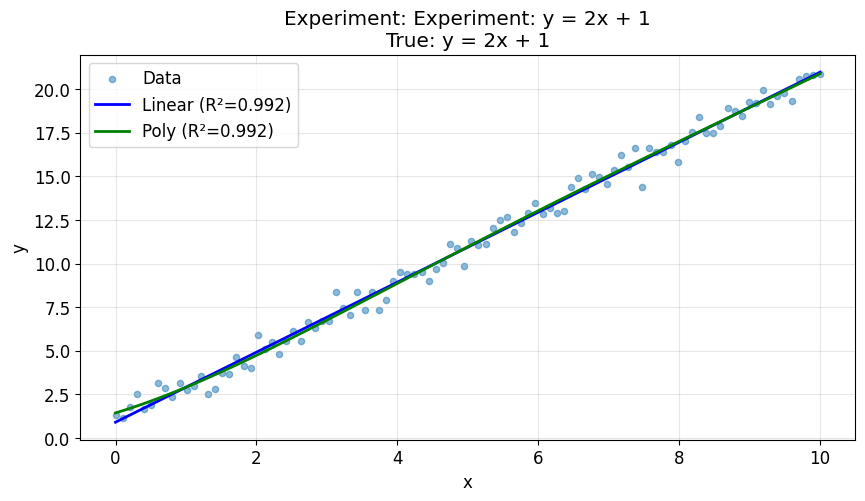



实验结论
-> 线性回归效果很好，数据可能是线性关系


In [30]:
#@title ##6.3 自主实验区
#@markdown ### 使用说明
#@markdown
#@markdown ---
#@markdown
#@markdown **1.模式选择**
#@markdown - `preset`: 使用预设的5种数据类型
#@markdown - `custom`: 自己输入数学公式
#@markdown
#@markdown **2. 预设数据类型说明**
#@markdown | 类型 | 公式 | 适用场景 |
#@markdown |------|------|----------|
#@markdown | linear | y = 2x + 3 | 线性关系 |
#@markdown | quadratic | y = x² - 2x + 1 | 二次函数 |
#@markdown | trig | y = sin(x) + 0.5x | 三角函数 |
#@markdown | freefall | y = 0.5gx² | 自由落体 |
#@markdown | exponential | y = e^(0.3x) | 指数增长 |
#@markdown
#@markdown **3. 自定义公式写法**
#@markdown - 变量用 `x`
#@markdown - 乘法用 `*`，幂用 `**`
#@markdown - 数学函数加 `np.` 前缀
#@markdown
#@markdown | 数学表达式 | 代码写法 |
#@markdown |-----------|---------|
#@markdown | x² + 2x + 1 | `x**2 + 2*x + 1` |
#@markdown | sin(x) | `np.sin(x)` |
#@markdown | cos(2x) | `np.cos(2*x)` |
#@markdown | eˣ | `np.exp(x)` |
#@markdown | ln(x) | `np.log(x)` |
#@markdown | √x | `np.sqrt(x)` |
#@markdown
#@markdown **4. 参数建议**
#@markdown - 噪声水平: 0.05~0.1 适合观察，0.2+ 模拟真实数据
#@markdown - 数据点数: 100 一般够用，复杂公式用 200+
#@markdown
#@markdown **5. X 轴范围说明**
#@markdown - `x_min`: X 的最小值（起点）
#@markdown - `x_max`: X 的最大值（终点）
#@markdown - 数据点会在 [x_min, x_max] 之间均匀分布
#@markdown
#@markdown | 公式 | 推荐范围 | 原因 |
#@markdown |------|---------|------|
#@markdown | sin(x) | 0 ~ 6.28 | 一个完整周期 (2π) |
#@markdown | ln(x) | 0.1 ~ 10 | 避免 ln(0) 错误 |
#@markdown | √x | 0 ~ 10 | 避免负数开根号 |
#@markdown | 自由落体 | 0 ~ 5 | 模拟5秒内落体 |
#@markdown
#@markdown ---
#@markdown ###  实验参数

#@markdown **模式选择**
mode = "preset" #@param ["preset", "custom"]

#@markdown **【预设模式】数据类型**
data_type = "linear" #@param ["linear", "quadratic", "trig", "freefall", "exponential"]

#@markdown **【自定义模式】输入公式**
custom_formula = "np.sin(x) + 0.5*x" #@param {type:"string"}

#@markdown ---
#@markdown **数据点数量**
n_points = 100 #@param {type:"slider", min:50, max:500, step:50}

#@markdown **噪声水平**
noise_level = 0.1 #@param {type:"slider", min:0, max:0.5, step:0.05}

#@markdown **X 轴范围**
x_min = 0 #@param {type:"number"}
x_max = 10 #@param {type:"number"}

#@markdown ---

import numpy as np

print("=" * 50)
print("实验配置")
print("=" * 50)

x = np.linspace(x_min, x_max, n_points)

if mode == "preset":
    x, y, formula = create_custom_data(
        data_type,
        n_points=n_points,
        noise_level=noise_level,
        x_range=(x_min, x_max)
    )
    print(f"  模式: 预设 - {data_type}")
else:
    try:
        y_true = eval(custom_formula)
        noise = np.random.normal(0, noise_level * np.std(y_true), n_points)
        y = y_true + noise
        formula = custom_formula
        print(f"  模式: 自定义公式")
        print(f"  公式: {custom_formula}")
    except Exception as e:
        print(f"  公式错误: {e}")
        print("  使用默认公式: x**2")
        y = x**2 + np.random.normal(0, noise_level, n_points)
        formula = "x**2"

print(f"  数据点: {n_points}")
print(f"  噪声: {noise_level*100:.0f}%")
print(f"  X 范围: [{x_min}, {x_max}]")
print("=" * 50)

result = run_experiment(x, y, formula, f"Experiment: {formula}")

print("\n" + "=" * 50)
print("实验结论")
print("=" * 50)
if result['poly_r2'] > result['lr_r2'] + 0.1:
    print("-> 多项式明显优于线性回归，数据可能是非线性的")
elif result['lr_r2'] > 0.95:
    print("-> 线性回归效果很好，数据可能是线性关系")
else:
    print("-> 两种方法效果都一般，可能需要其他模型")
print("=" * 50)

---
<a id='appendix'></a>
# 附录

## A. 常见问题

**Q1: 模型下载失败怎么办？**
- 检查网络连接
- 手动从 Google Drive 下载并上传

**Q2: GPU 内存不足？**
- 减少数据点数量
- 使用 `torch.cuda.empty_cache()` 清理内存

## B. 扩展阅读

1. [论文原文 (Nature Machine Intelligence)](https://www.nature.com/articles/s42256-025-01126-3)
2. [arXiv 预印本](https://arxiv.org/abs/2503.07994)
3. [GitHub 仓库](https://github.com/Jie0618/PhysicsRegression)

## C. 术语表

| 术语 | 解释 |
|------|------|
| 符号回归 | 从数据中发现数学公式 |
| MCTS | 蒙特卡洛树搜索 |
| GP | 遗传编程 |
| Transformer | 一种神经网络架构 |

---

##  恭喜完成本课程！

你已经学习了：
-  传统拟合方法的原理与局限
-  符号回归的核心概念
-  PhyE2E 模型的使用方法
-  真实物理案例的探索
-  多种方法的对比分析

---

**参考文献**

Ying, J., Lin, H., Yue, C. et al. A neural symbolic model for space physics. *Nat Mach Intell* **7**, 1726–1741 (2025). https://doi.org/10.1038/s42256-025-01126-3.